# create the evaluation matrix for each of the workers, assess if the worker is fraudulent

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib as mpl
from datetime import datetime, date, time, timedelta

In [2]:
# import data

# make sure to select which experiments data you want to analyze 
#raw_df = pd.read_csv('experiment1_data.csv')
raw_df = pd.read_csv('experiment2_data.csv')
raw_df.columns

Index([u'Unnamed: 0', u'_unit_id', u'_created_at', u'_golden', u'_id',
       u'_missed', u'_started_at', u'_tainted', u'_channel', u'_trust',
       u'_worker_id', u'_country', u'_region', u'_city', u'_ip',
       u'please_make_your_relevancy_judgment', u'orig__created_at',
       u'orig__golden', u'orig__unit_id', u'_updated_at', u'endurl', u'nil',
       u'please_make_your_relevancy_judgment_gold',
       u'please_make_your_relevancy_judgment_gold_reason', u'starturl',
       u'type'],
      dtype='object')

### gather basic information about each worker
using dictionaries to ensure no misalignment in assessing them 

In [3]:
# create first pass of lists for easy to gather worker metrics 

# create the ultimate worker id list
worker_ids = []
for line in raw_df.groupby('_worker_id'):
    worker_ids.append(line[0])
    
# dict of created times and ids
created_at_dict = dict()
for line in raw_df.groupby('_worker_id')['_created_at']:
    created_at_dict[line[0]] = line[1]
    
# dict of started times and ids    
started_at_dict = dict()
for line in raw_df.groupby('_worker_id')['_started_at']:
    started_at_dict[line[0]] = line[1]
    
# dict of scores and ids
scores_dict = dict()
for line in raw_df.groupby('_worker_id')['please_make_your_relevancy_judgment']:
    scores_dict[line[0]] = list(line[1]) #coerce to list bc i hate indexing on the series
    
# dict of trust and ids
trust_dict = dict()
for line in raw_df.groupby('_worker_id'):
    trust_dict[line[0]] = line[1]['_trust'][line[1]['_trust'].keys()[1]]
    
# get job counts, variance, and mean for each worker 
worker_job_count = {}
worker_variance = {}
worker_mean = {}
for worker_id in worker_ids:
    scores = scores_dict[worker_id]
    worker_job_count[worker_id] = len(scores)
    worker_variance[worker_id] = np.var(scores)
    worker_mean[worker_id] = np.mean(scores)

### time stamp difference analysis 

In [4]:
## identify diversity in job creation, job start time differences  

# takes a list of datetime strings and returns a list of datetime objects
def make_list_datetime(list_of_time_strings):
    date_time_list = []
    for time in list_of_time_strings:
        date_time_list.append(datetime.strptime(time, "%m/%d/%Y %H:%M:%S"))
    return date_time_list


# take in lists of creation, start datetime strings, output list of differences in seconds 
def creation_start_dif(creation_list, start_list):
    # make all into datetime objects 
    creation_datetimes = make_list_datetime(creation_list)
    start_datetimes = make_list_datetime(start_list)
    
    # iterate through to calculate each difference 
    creation_start_diffs = []
    
    indexer = range(0,len(creation_list))
    for index in indexer:
        diff = creation_datetimes[index] - start_datetimes[index]
        creation_start_diffs.append(diff.total_seconds())    
    return creation_start_diffs


def get_diversity_score(created_dict, started_dict ):

    # produce the list of differences for each worker 
    creation_start_diff_dict = {}    
    outer_indexer = range(0, len(created_dict))
    
    #go through each worker 
    for outer_index in outer_indexer:       

        # select the worker and his creation and start time
        worker_id = worker_ids[outer_index]        
        creation = created_at_dict[worker_id]
        start = started_at_dict[worker_id]
        
        # go through each pair of times and get the difference         
        indexer = range(0,len(start))
        for index in indexer:
            diff_list = creation_start_dif(creation, start)
            creation_start_diff_dict[worker_id] = diff_list
        
    
    # calculate the diversity measure
    diversity_dict = {}
    
    for worker_id in worker_ids:
        uniques = len(set(creation_start_diff_dict[worker_id])) + 0.0
        diversity = uniques/len(creation_start_diff_dict[worker_id])
        diversity_dict[worker_id] = diversity
        
    
    return diversity_dict

diversity_score_dict = get_diversity_score(created_at_dict, started_at_dict)

### minority judgments 

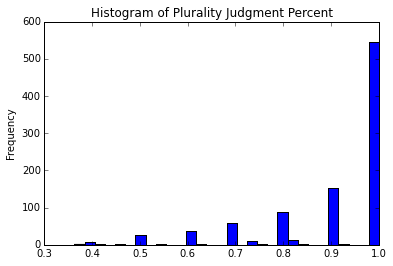

In [5]:
# calculate the minority judgments segment 
## detect majority judgments (and how much of a majority)

modes = []
mode_counts = []
judgment_counts = []
plurality_percentages = []
plurality_judgment = dict()

for line in raw_df.groupby('_unit_id'):
    unit_id = line[0]
    judgments = line[1]['please_make_your_relevancy_judgment']
    mode = judgments.mode()
    mode = int(mode[0])
    modes.append(mode)
    mode_count = 0
    for judgment in judgments:
        if judgment == mode:
            mode_count += 1
    mode_counts.append(mode_count)
    judgment_count = len(judgments)
    judgment_counts.append(judgment_count)
    plurality_percentage = (mode_count +0.0)/judgment_count
    plurality_percentages.append(plurality_percentage)
    plurality_judgment[line[0]] = mode, plurality_percentage
    

pd.Series(data= plurality_percentages).plot(kind = 'hist', bins=30, title = 'Histogram of Plurality Judgment Percent')

In [6]:
# detect minority judgments by worker
worker_is_in_the_minority = dict(zip(worker_ids, [0]*len(worker_ids)))

# go through each row
for line in raw_df.iterrows():
    worker_id = line[1]['_worker_id']
    worker_judgment = line[1]['please_make_your_relevancy_judgment']
    unit_id = line[1]['_unit_id']
    
    majority_judgment = plurality_judgment[unit_id][0]

    # in the first pass i don't take into account how much of a majority/plurality it is   
    is_minority =  (worker_judgment != majority_judgment)

    if is_minority == 1:
        worker_is_in_the_minority[worker_id] += 1

## combine into a single data frame 

In [43]:
# for no good reason, order isn't being preserved, so now i'm going to be careful and always use a key
def insert_dictionary(dictionary, new_value_name, dataframe):
    temp_list = []
    for key in dictionary:
        temp_list.append(dictionary[key])
    dataframe[new_value_name] = temp_list    
    return dataframe 

In [44]:
# consolidate into a single dataframe 
worker_assessments = pd.DataFrame()
worker_assessments['_worker_id'] = worker_ids
worker_assessments = insert_dictionary(worker_job_count,'job_count', worker_assessments)
worker_assessments = insert_dictionary(worker_variance,'variance', worker_assessments)
worker_assessments = insert_dictionary(worker_mean,'mean', worker_assessments)
worker_assessments = insert_dictionary(diversity_score_dict,'diversity_score', worker_assessments)
worker_assessments = insert_dictionary(worker_is_in_the_minority,'minority_count', worker_assessments)
worker_assessments['minority_percentage'] = worker_assessments['minority_count']/worker_assessments['job_count']
del worker_assessments['minority_count']

# evaluate each of the metrics and come up with critera to binerize them into good/bad categories (1 is bad)

In [81]:
# functions to make this work better

# normalize a list of numbers so that the scale isn't such an issue (better for clusterin on raw data)
def normalize(list_of_numbers):
    min_value = min(list_of_numbers)
    list_less_min = list_of_numbers - min_value
    max_value = max(list_less_min)
    normalized_values = list_less_min / max_value
    return normalized_values

# calculate confidence intervals
def confidence_interval(list_of_numbers):    
    mu = np.mean(list_of_numbers)
    sigma = np.std(list_of_numbers)
        
    ci_low = mu - 2*sigma
    ci_high = mu + 2*sigma
    
    return ci_low, ci_high

# apply the confidence interval to detect anomalies
def apply_ci(list_of_numbers, ci_tuple):
    validity_list = []
    for number in list_of_numbers:
        if number > ci_tuple[1]:
            validity_list.append(1)
        elif number < ci_tuple[0]:
            validity_list.append(1)
        else:
            validity_list.append(0)
    return validity_list

In [82]:
# fetch the confidence intervals and judge each value as inside/outside of it and add a column to sum up, create df:
ci_dict = {}
ci_asses_dict = {}
binary_worker_assessments = pd.DataFrame()
for column in worker_assessments.columns:
    # obviously do not apply to the worker id column
    if column == '_worker_id':
        binary_worker_assessments[column] = worker_assessments[column]
        continue
    ci_dict[column] = confidence_interval(worker_assessments[column])
    ci_asses_dict[column] = apply_ci(worker_assessments[column], ci_dict[column])
    binary_worker_assessments[column] = ci_asses_dict[column]
binary_worker_assessments['agg_score']  = binary_worker_assessments.ix[:, binary_worker_assessments.columns != '_worker_id'].apply(sum, axis=1)
binary_worker_assessments['is_bad'] = binary_worker_assessments['agg_score'].apply(lambda x: x >= 3)

# add the is bad to the worker_assessment data frame
# double check that the order is the same
print sum(worker_assessments['_worker_id'] != binary_worker_assessments['_worker_id'])
worker_assessments['is_bad'] = binary_worker_assessments['is_bad']
print sum(binary_worker_assessments.is_bad)

0
3


### cluster on the matrix to identify the fraud vs good workers 

In [84]:
from sklearn.cluster import KMeans

#make the pure dataframe for the clustering
data_columns = ['job_count', 'variance', 'mean', 'diversity_score', 'minority_percentage']
Y = binary_worker_assessments.ix[:, data_columns]

# kmeans clustering
kmeans2= KMeans(n_clusters = 2, random_state = 27, init= 'random' )
cluster_predictions2 = kmeans2.fit_predict(Y)
cluster_predictions2
print sum(cluster_predictions2 != worker_assessments.is_bad)
print sum(cluster_predictions2)

#add to the data frame
worker_assessments['is_bad_cluster'] = cluster_predictions2

1
4


### visual assessment of the crude approach

is_bad
False    Axes(0.125,0.125;0.775x0.775)
True     Axes(0.125,0.125;0.775x0.775)
Name: job_count, dtype: object

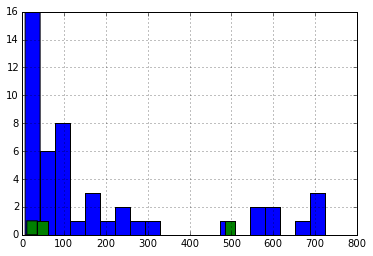

In [85]:
worker_assessments.groupby('is_bad')['job_count'].hist(bins = 20)

is_bad
False    Axes(0.125,0.125;0.775x0.775)
True     Axes(0.125,0.125;0.775x0.775)
Name: variance, dtype: object

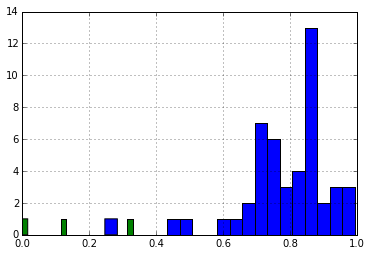

In [86]:
worker_assessments.groupby('is_bad')['variance'].hist(bins = 20)

is_bad
False    Axes(0.125,0.125;0.775x0.775)
True     Axes(0.125,0.125;0.775x0.775)
Name: mean, dtype: object

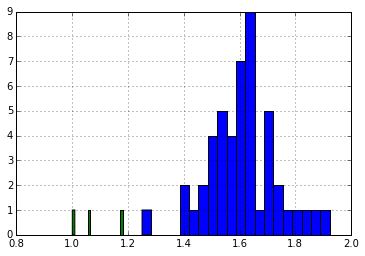

In [87]:
worker_assessments.groupby('is_bad')['mean'].hist(bins = 20)

is_bad
False    Axes(0.125,0.125;0.775x0.775)
True     Axes(0.125,0.125;0.775x0.775)
Name: diversity_score, dtype: object

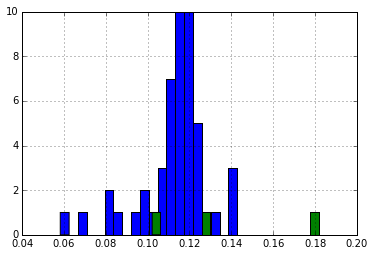

In [88]:
worker_assessments.groupby('is_bad')['diversity_score'].hist(bins = 20)

is_bad
False    Axes(0.125,0.125;0.775x0.775)
True     Axes(0.125,0.125;0.775x0.775)
Name: minority_percentage, dtype: object

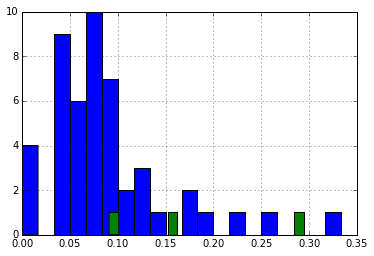

In [89]:
worker_assessments.groupby('is_bad')['minority_percentage'].hist(bins = 20)

### visually assess the clustering appraoch

is_bad_cluster
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: job_count, dtype: object

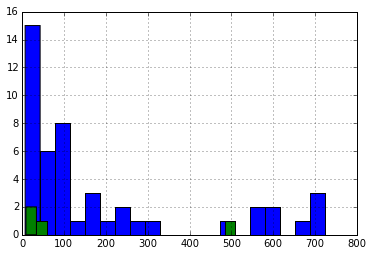

In [90]:
worker_assessments.groupby('is_bad_cluster')['job_count'].hist(bins = 20)

is_bad_cluster
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: variance, dtype: object

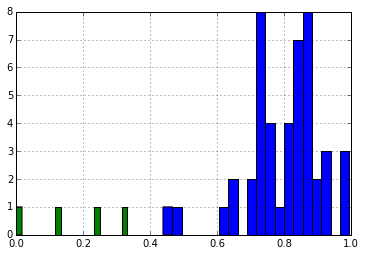

In [91]:
worker_assessments.groupby('is_bad_cluster')['variance'].hist(bins = 20)

is_bad_cluster
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: mean, dtype: object

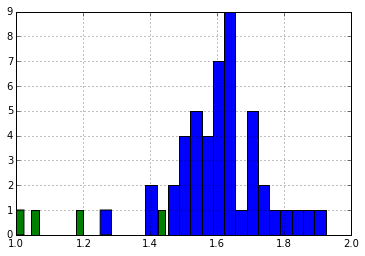

In [92]:
worker_assessments.groupby('is_bad_cluster')['mean'].hist(bins = 20)

is_bad_cluster
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: diversity_score, dtype: object

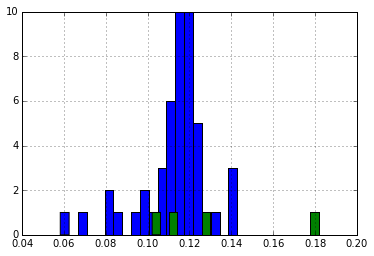

In [93]:
worker_assessments.groupby('is_bad_cluster')['diversity_score'].hist(bins = 20)

is_bad_cluster
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: minority_percentage, dtype: object

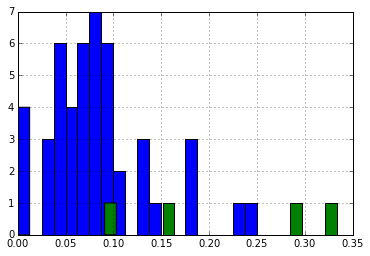

In [94]:
worker_assessments.groupby('is_bad_cluster')['minority_percentage'].hist(bins = 20)

### by somewhat crude visual inspection, it looks like clustering on the binarized worker values leads to a really good selection of the bad workers. it managed to not punish the workers who did a lot of tasks but were actually performing well, and consistently got the workers with high minority percentages, exceedingly low means, and low variances. it's actually a pretty good way to figure out whether these values matter.

# output to the database

In [25]:
# output to the worker table in the db

# need libraries for conneting with databse 
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# create sql engine
dbname = 'urx'
username = 'noahburbank'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [26]:
# make sure to adjust the table name so that the two experiments are distinct 
# upload to the database
worker_assessments.to_sql('worker_table_exp1', engine, if_exists = 'replace')